In [1]:
# Allow relative import
import os
import sys
print(os.path)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


<module 'posixpath' from '/usr/lib/python3.8/posixpath.py'>


In [2]:
from src.Objects import Process, I

processes = [
    Process(
        func=lambda x, y, z: x + y + z,
        comment="Demo process a",
        config_inputs=[
            I('foo.bar', as_='x'),
        ],
        state_inputs=[
            I('info.today', as_='y'),
            I('info.hour', as_='z')
        ],
        state_outputs=[
            I('_result', as_='info.tomorrow'),
        ]
    ),
    Process(
        func=lambda x, y: x + y,
        comment="Demo process b",
        config_inputs=[
            I('foo.bar', as_='x'),
        ],
        state_inputs=[
            I('info.tomorrow', as_='y'),
        ],
        state_outputs=[
            I('_result', as_='info.today'),
        ]
    ),
    Process(
        func=lambda x, y: x + y,
        comment="Demo process c",
        config_inputs=[
            I('foo.bar', as_='x'),
        ],
        state_inputs=[
            I('info.tomorrow', as_='y'),
        ],
        state_outputs=[
            I('_result', as_='info.today'),
        ]
    ),
    Process(
        func=lambda x, y: x + y,
        comment="Demo process d",
        config_inputs=[
            I('foo.bar', as_='x'),
        ],
        state_inputs=[
            I('info.today', as_='y'),
        ],
        state_outputs=[
            I('_result', as_='info.tomorrow'),
            I('_result', as_='log.extra'),
        ]
    ),
]


In [3]:
inputs_list = list(set([inp.from_ for p in processes for inp in p.state_inputs] + [inp.as_ for p in processes for inp in p.state_outputs]))
inputs_list

['info.today', 'info.hour', 'log.extra', 'info.tomorrow']

In [4]:
inputs_map = dict((inp, i) for i, inp in enumerate(inputs_list))
inputs_map

{'info.today': 0, 'info.hour': 1, 'log.extra': 2, 'info.tomorrow': 3}

In [5]:
links = []
for p in processes:
    input_links = [inputs_map[ip.from_] for ip in p.state_inputs]
    # input_links = [ip.from_ for ip in p.state_inputs]
    output_links = [inputs_map[ip.as_] for ip in p.state_outputs]
    # output_links = [ip.as_ for ip in p.state_outputs]
    links.append((p.comment, input_links, output_links))
links

[('Demo process a', [0, 1], [3]),
 ('Demo process b', [3], [0]),
 ('Demo process c', [3], [0]),
 ('Demo process d', [0], [3, 2])]

In [6]:
from ipycanvas import Canvas
from math import pi
from collections import namedtuple
from scipy.interpolate import interp1d
import numpy as np

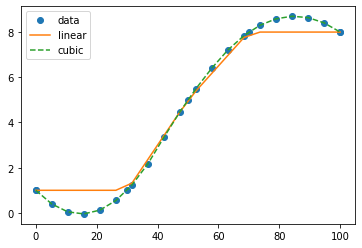

In [7]:
x = np.array([0, 30, 50, 70, 100])
y = np.array([1,1, 5,8,8])
y
f = interp1d(x, y)
f
f2 = interp1d(x, y, kind=2, fill_value="extrapolate")

xnew = np.linspace(min(x), max(x), num=20, endpoint=True)
ynew=f2(xnew)
ynew

import matplotlib.pyplot as plt

plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.scatter(xnew, ynew)
plt.legend(['data', 'linear', 'cubic'], loc='best')

plt.show()

In [8]:
def spline_curve_points(x1, y1, x2, y2, s = 10, c = 8):
    x = np.array([x1, x1 + s, x2 - s, x2])
    y = np.array([y1, y1, y2, y2])
    # f = interp1d(x, y)
    f2 = interp1d(x, y, kind='cubic')

    xnew = np.linspace(min(x), max(x), num=c, endpoint=True)
    ynew=f2(xnew)
    points = [(ptx, ynew[i]) for i, ptx in enumerate(xnew)]
    return points
spline_curve_points(0, 0, 100, 100, 10, 4)


[(0.0, 0.0),
 (33.333333333333336, 23.045267489711932),
 (66.66666666666667, 76.95473251028807),
 (100.0, 100.0)]

In [9]:
from scipy.special import comb

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def bezier_curve(x1, y1, x2, y2, s = 10, nTimes=10):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """
    xPoints = np.array([x1, x1 + s, x2 - s, x2])
    yPoints = np.array([y1, y1, y2, y2])

    nPoints = len(xPoints)
    # xPoints = np.array([p[0] for p in points])
    # yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    points = [(ptx, yvals[i]) for i, ptx in enumerate(xvals)]
    return points

In [10]:
def bezier_curve_canvas(canvas, p_start, p_end):
    canvas.line_join = 'bevel'
    canvas.line_cap = 'round'
    canvas.begin_path()
    
    points = bezier_curve(p_start[0], p_start[1], p_end[0], p_end[1], 50)
    canvas.move_to(*points[0])
    for pt in points[1:]:
        canvas.line_to(*pt) 
    canvas.stroke()

In [11]:
canvas = Canvas(width=800, height=800)

Rect_Params = namedtuple('Rect_Params', 'x y w h')

process_x_pos = 10
process_width = 100
process_height = 100

state_x_pos = 300
state_width = 100
state_height = 100


process_rects = [Rect_Params(process_x_pos, ((process_height +20) * i) + 10, process_width, process_height) for i in range(len(processes))]
state_item_rects = [Rect_Params(state_x_pos, ((state_height +20) * i) + 10, state_width, state_height) for i in range(len(inputs_list))]
for p in process_rects: canvas.stroke_rect(*p)
for p in state_item_rects: canvas.stroke_rect(*p)

for i, p in enumerate(processes):
    process_rect = process_rects[i]
    canvas.fill_text(p.comment, process_rect.x + 5, process_rect.y + 20)


for i, p in enumerate(inputs_list):
    state_item_rect = state_item_rects[i]
    canvas.fill_text(p, state_item_rect.x + 5, state_item_rect.y + 20)



for i, link in enumerate(links):
    process_rect = process_rects[i]
    for j in link[1]:
        state_rect = state_item_rects[j]
        canvas.stroke_style = 'blue'
        p_start = [process_rect.x + process_rect.w,process_rect.y + 10]
        p_end = [state_rect.x, state_rect.y + 10*i]
        bezier_curve_canvas(canvas, p_start, p_end)


    for j in link[2]:
        state_rect = state_item_rects[j]
        canvas.stroke_style = 'red'
        canvas.begin_path()
        p_start = [process_rect.x + process_rect.w,process_rect.y + process_rect.h -10]
        p_end = [state_rect.x, state_rect.y + 10 * i]
        bezier_curve_canvas(canvas, p_start, p_end)
        canvas.stroke()
    # break

canvas

Canvas(height=800, width=800)

In [12]:
from src.analysis.link_inputs_processes import link_processes_to_state


In [13]:
canvas = Canvas(width=800, height=800)
link_processes_to_state(canvas, processes)

Canvas(height=800, width=800)